## CGAN で PyTorch実装を学ぶ
- Reference
  - https://github.com/eriklindernoren/PyTorch-GAN
  - https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py
  

In [1]:
import os
import datetime
import numpy as np
import pandas as pd

In [2]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [4]:
import torch.nn as nn
#import torch.nn.functional as F
import torch

In [5]:
#torch.__version__

In [6]:
DATA_DIR_PATH = '/content/drive/My Drive/project/ML/pytorch-gan/data'

OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '04_out')

In [7]:
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [8]:
cuda = True if torch.cuda.is_available() else False
print(cuda)

True


In [10]:
class Generator(nn.Module):
    def __init__(self, img_shape, latent_dim, n_classes):
        super(Generator, self).__init__()

        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.n_classes = n_classes

        self.label_emb = nn.Embedding(self.n_classes, self.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim + self.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [11]:
class Discriminator(nn.Module):
    def __init__(self, img_shape, n_classes):
        super(Discriminator, self).__init__()

        self.img_shape = img_shape
        self.n_classes = n_classes

        self.label_embedding = nn.Embedding(self.n_classes, self.n_classes)

        self.model = nn.Sequential(
            nn.Linear(self.n_classes + int(np.prod(self.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [14]:
img_size = 28
img_shape = (1, img_size, img_size)

In [15]:
# Configure data loader
MNIST_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, 'mnist')

batch_size = 64

os.makedirs(MNIST_DATA_DIR_PATH, exist_ok=True)

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        MNIST_DATA_DIR_PATH,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [26]:
class CGAN:
    def __init__(self, data_loader, img_shape, latent_dim=1, n_classes=10):
        self.history = pd.DataFrame({}, columns=[
            'epoch', 'batche_i', 'd_loss', 'g_loss', 'elapsed_time'])

        self.data_loader = data_loader

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.generator_name = 'generator_model'

        self.train_cnt = 0

        self.img_shape = img_shape
        self.n_classes = n_classes
        self.latent_dim = latent_dim

        self.adversarial_loss = torch.nn.MSELoss()

        self.generator = Generator(self.img_shape, self.latent_dim, self.n_classes)
        self.discriminator = Discriminator(self.img_shape, self.n_classes)

        if cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()

        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999

        # Optimizers
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))

    def train(self, n_epochs, sample_interval=-1):
        self.train_cnt += 1

        #Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

        print(datetime.datetime.now().isoformat(), 'Start', self.train_cnt)

        start_time = datetime.datetime.now()

        step_cnt = 1

        for epoch in range(1, n_epochs+1):

            for i, (imgs, labels) in enumerate(self.data_loader, 1):
                batch_size = imgs.shape[0]

                # Adversarial ground truths
                valid = Variable(self.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
                fake = Variable(self.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

                # Configure input
                real_imgs = Variable(imgs.type(self.FloatTensor))
                labels = Variable(labels.type(self.LongTensor))

                # Train Generator
                self.optimizer_G.zero_grad()

                # Sample noise and labels as generator input
                z = Variable(self.FloatTensor(np.random.normal(0, 1, (batch_size, self.latent_dim))))
                gen_labels = Variable(self.LongTensor(np.random.randint(0, self.n_classes, batch_size)))

                # Generate a batch of images
                gen_imgs = self.generator(z, gen_labels)

                # Loss measures generator's ability to fool the discriminator
                validity = self.discriminator(gen_imgs, gen_labels)
                g_loss = self.adversarial_loss(validity, valid)

                g_loss.backward()
                self.optimizer_G.step()

                # Train Discriminator
                self.optimizer_D.zero_grad()

                # Loss for real images
                validity_real = self.discriminator(real_imgs, labels)
                d_real_loss = self.adversarial_loss(validity_real, valid)

                # Loss for fake images
                validity_fake = self.discriminator(gen_imgs.detach(), gen_labels)
                d_fake_loss = self.adversarial_loss(validity_fake, fake)

                # Total discriminator loss
                d_loss = (d_real_loss + d_fake_loss) / 2

                d_loss.backward()
                self.optimizer_D.step()

                batches_done = epoch * len(self.data_loader) + i

                elapsed_time = datetime.datetime.now() - start_time

                self.history = self.history.append({
                    'epoch': epoch,
                    'batch_i': i,
                    'd_loss': d_loss.item(),
                    'g_loss': g_loss.item(),
                    'elapsed_time': elapsed_time
                }, ignore_index=True)


                if sample_interval > 0 and step_cnt % sample_interval == 0:
                    print(
                        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                        % (epoch, n_epochs, i, len(self.data_loader), d_loss.item(), g_loss.item())
                    )

                    self.sample_image(epoch, i, n_row=10)

                step_cnt += 1

        print(datetime.datetime.now().isoformat(), 'End')

    def sample_image(self, epoch, batch_i, n_row):
        """Saves a grid of generated digits ranging from 0 to n_classes"""
        # Sample noise
        z = Variable(self.FloatTensor(np.random.normal(0, 1, (n_row ** 2, self.latent_dim))))

        # Get labels ranging from 0 to n_classes for n rows
        labels = np.array([num for _ in range(n_row) for num in range(n_row)])
        labels = Variable(self.LongTensor(labels))

        gen_imgs = self.generator(z, labels)

        file_name = os.path.join(self.img_save_dir, '{}_{}_{}.png'.format(self.train_cnt, epoch, batch_i))
        save_image(gen_imgs.data, file_name, nrow=n_row, normalize=True)

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'g_loss']
        self.history[columns].plot()

    def save_models(self, file_suffix=None):
        self.save_state_dict(self.generator, self.generator_name, file_suffix)

    def save_state_dict(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_model_file_name(model_name, file_suffix))
        torch.save(model.state_dict(), file_path)
        print('Model saved.', model_name)

    def _create_model_file_name(self, model_name, suffix=None):
        processor = 'gpu' if cuda else 'cpu'

        if suffix:
            return '{}_{}_{}.pth'.format(model_name, processor, suffix)
        else:
            return '{}_{}.pth'.format(model_name, processor)

2020-09-06T18:29:05.112058 Start 1
[Epoch 1/1] [Batch 50/938] [D loss: 0.442886] [G loss: 1.429269]
[Epoch 1/1] [Batch 100/938] [D loss: 0.135243] [G loss: 0.380811]
[Epoch 1/1] [Batch 150/938] [D loss: 0.083121] [G loss: 0.425410]
[Epoch 1/1] [Batch 200/938] [D loss: 0.113265] [G loss: 0.549737]
[Epoch 1/1] [Batch 250/938] [D loss: 0.093385] [G loss: 0.503917]
[Epoch 1/1] [Batch 300/938] [D loss: 0.152333] [G loss: 0.275332]
[Epoch 1/1] [Batch 350/938] [D loss: 0.174022] [G loss: 0.218950]
[Epoch 1/1] [Batch 400/938] [D loss: 0.226328] [G loss: 0.161791]
[Epoch 1/1] [Batch 450/938] [D loss: 0.103389] [G loss: 0.529275]
[Epoch 1/1] [Batch 500/938] [D loss: 0.107928] [G loss: 0.569352]
[Epoch 1/1] [Batch 550/938] [D loss: 0.090730] [G loss: 0.972160]
[Epoch 1/1] [Batch 600/938] [D loss: 0.216736] [G loss: 0.163725]
[Epoch 1/1] [Batch 650/938] [D loss: 0.099982] [G loss: 0.736322]
[Epoch 1/1] [Batch 700/938] [D loss: 0.100082] [G loss: 0.444399]
[Epoch 1/1] [Batch 750/938] [D loss: 0.091

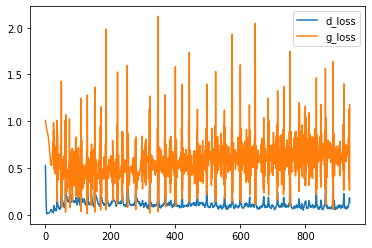

In [27]:
n_epochs = 1
sample_interval = 50

cgan = CGAN(dataloader, img_shape)
cgan.train(n_epochs, sample_interval)

cgan.plot_hisotry()

In [28]:
cgan.save_models()

Model saved. generator_model
